<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <center><h1 style="font-size: 50px; color: white; text-shadow: 0 0 5px black, 0 0 5px black;"><b>4. Plane Classifier<br> Transfer Learning</b></h1></center>
    <center><h1 style="font-size: 30px; color: white;  text-shadow: 0 0 5px black, 0 0 5px black;">Computer Vision</h1></center>
    <br>
    <br>
    <br>
    <br>
    <br>
    <div style="color: white; margin-left:  5%; font-size: 20px;">
        <p>Realizado por: </p>
        <ul>
            <li>Beatriz Santos, nº 108593</li>
            <li>João Ferreira, nº 88639</li>
            <li>Rodrigo Sarroeira, nº 92761</li>
        </ul>
    </div>        
    <br>
    <br>
    <br><br></div>

In [1]:
import os
import pathlib
import pickle
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses, optimizers, applications
from tensorflow.keras.utils import image_dataset_from_directory
from keras.applications import EfficientNetB0, MobileNet, ResNet50
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomTranslation, RandomRotation, Flatten
from termcolor import colored

logging.disable(logging.WARNING)
logging.disable(logging.INFO)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...


<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">1. ResNet: Split Dataset</h1>
</div>

In [6]:
# Define parameters
BATCH_SIZE_2 = 40
IMG_SIZE_2 = (128, 128)
SEED = 1245
NUM_CLASSES = 7

dataset_location = "images\crop_new"

In [7]:
# Train dataset
train_data = image_dataset_from_directory(
    dataset_location,
    validation_split=0.3,
    subset='training',
    seed=SEED,
    shuffle=True,
    image_size=IMG_SIZE_2,
    batch_size=BATCH_SIZE_2)

Found 21000 files belonging to 7 classes.
Using 14700 files for training.


In [8]:
# Validation dataset
val_data = image_dataset_from_directory(
    dataset_location,
    validation_split=0.3,
    subset='validation',
    seed=SEED,
    shuffle=True,
    image_size=IMG_SIZE_2,
    batch_size=BATCH_SIZE_2)

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

Found 21000 files belonging to 7 classes.
Using 6300 files for validation.
The datasets were succesfully loaded...


In [11]:
print("There is {} batches of 40 images in the training dataset".format(len(train_data)))
print("There is {} batches of 40 images in the validation dataset".format(len(val_data)))

There is 368 batches of 40 images in the training dataset
There is 158 batches of 40 images in the validation dataset


<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">2. ResNet: Data Classes and Examples</h1>
</div>

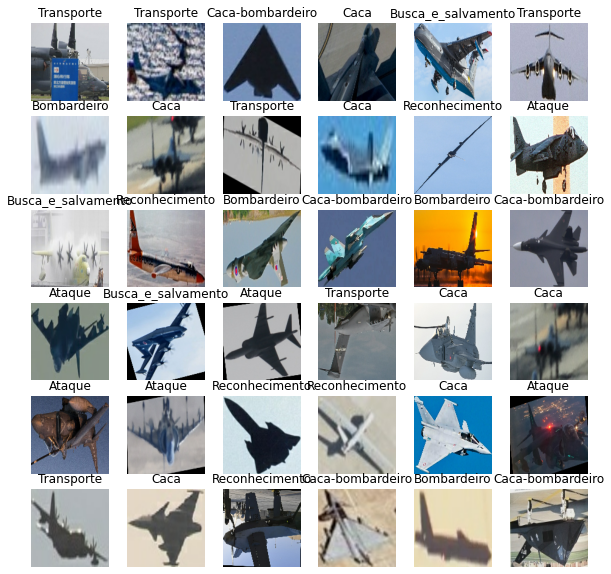

In [6]:
# Display examples of data
class_names = train_data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(36):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">3. ResNet: Trainning</h1>
</div>

In [7]:
# Keep images in memory
train_data = train_data.cache()
val_data = val_data.cache()
# Create prefetch for train,test,val data
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

In [8]:
# Augmentation layer
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal_and_vertical'))
data_augmentation.add(layers.RandomRotation(0.4))

In [9]:
# Feature extraction layer
# Input processing
preprocess_input = applications.resnet50.preprocess_input

# Create base model using ResNet50
IMG_SHAPE = IMG_SIZE_2 + (3,)
ResNetmodel = applications.ResNet50(input_shape=IMG_SHAPE,
                                   include_top=False,
                                   weights='imagenet')

# Freeze layers
ResNetmodel.trainable = False
ResNetmodel.summary()

# Classification layer
nClass = len(class_names)

global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nClass, activation='softmax')

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [10]:
# Chain layers with Functional api
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = ResNetmodel(x)
x = global_avg(x)
outputs = output_layer(x)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 7)                 14343 

In [11]:
# Compile model
lr_schedule = optimizers.schedules.CosineDecay(0.001, 500)
optimizer = optimizers.Adam(learning_rate=lr_schedule)
loss = losses.SparseCategoricalCrossentropy()

model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [12]:
# Train Model
EPOCHS = 5
ResNetmodel_history = model3.fit(train_data, validation_data=(val_data), epochs=EPOCHS)

Epoch 1/5
368/368 [==============================] - 559s 2s/step - loss: 1.3622 - accuracy: 0.5282 - val_loss: 1.0972 - val_accuracy: 0.6075
Epoch 2/5
368/368 [==============================] - 354s 961ms/step - loss: 0.9376 - accuracy: 0.6680 - val_loss: 1.0758 - val_accuracy: 0.6192
Epoch 3/5
368/368 [==============================] - 330s 898ms/step - loss: 0.9285 - accuracy: 0.6703 - val_loss: 1.0758 - val_accuracy: 0.6192
Epoch 4/5
368/368 [==============================] - 330s 896ms/step - loss: 0.9285 - accuracy: 0.6703 - val_loss: 1.0758 - val_accuracy: 0.6192
Epoch 5/5
368/368 [==============================] - 410s 1s/step - loss: 0.9285 - accuracy: 0.6703 - val_loss: 1.0758 - val_accuracy: 0.6192


In [13]:
# Finetune layer of base model
ResNetmodel.trainable = True
for layer in ResNetmodel.layers[:100]:
    layer.trainable = False

# Recompile model
optimizer = optimizers.RMSprop(learning_rate=lr_schedule)
model3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [14]:
# Continue model training
fine_tune_epoch = 1
NEW_EPOCH = EPOCHS + fine_tune_epoch

ResNetmodel_history_fine = model3.fit(train_data,
                         validation_data=(val_data),
                         epochs=NEW_EPOCH,
                         initial_epoch=ResNetmodel_history.epoch[-1])

Epoch 5/6
368/368 [==============================] - 1151s 3s/step - loss: 0.9013 - accuracy: 0.7195 - val_loss: 0.3756 - val_accuracy: 0.8754
Epoch 6/6
368/368 [==============================] - 1134s 3s/step - loss: 0.1072 - accuracy: 0.9716 - val_loss: 0.2841 - val_accuracy: 0.8989


<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">4. ResNet: Evaluation</h1>
</div>

In [15]:
y_pred = model3.predict(val_data)
y_pred = tf.argmax(y_pred, axis=1)

158/158 [==============================] - 99s 621ms/step


In [16]:
y_true = tf.concat([y for x, y in val_data], axis=0)
y_true = tf.argmax(y_true, axis=1)

InvalidArgumentError: {{function_node __wrapped__ArgMax_device_/job:localhost/replica:0/task:0/device:CPU:0}} Expected dimension in the range [-1, 1), but got 1 [Op:ArgMax]

In [18]:
acc = ResNetmodel_history.history['accuracy']
val_acc = ResNetmodel_history.history['val_accuracy']
loss = ResNetmodel_history.history['loss']
val_loss = ResNetmodel_history.history['val_loss']

In [19]:
epochs_range = ResNetmodel_history.epoch
range(0, max(epochs_range))

range(0, 4)

Text(0.5, 1.0, 'Training and Validation Loss')

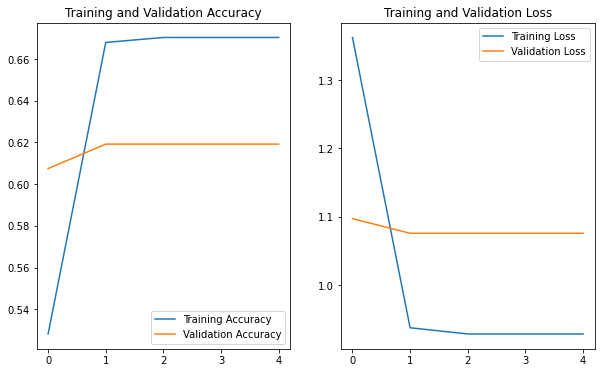

In [20]:
plt.figure(2, figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(0, max(epochs_range) + 1), acc, label='Training Accuracy')
plt.plot(range(0, max(epochs_range) + 1), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(0, max(epochs_range) + 1), loss, label='Training Loss')
plt.plot(range(0, max(epochs_range) + 1), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

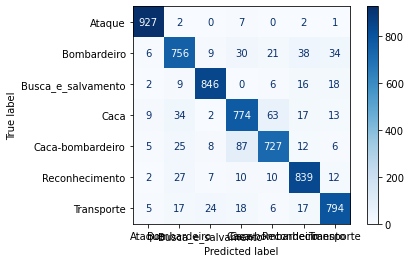

In [21]:
# Confusion Matrix
cm3 = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [22]:
accuracy = accuracy_score(y_true, y_pred)
print("Accurary =", accuracy)

Accurary = 0.8988888888888888


<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">5. MobileNet: Split Dataset</h1>
</div>

In [17]:
# Define parameters
BATCH_SIZE = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
SEED = 1245
NUM_CLASSES = 7

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_location,
  labels='inferred',
  label_mode = 'categorical',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

Found 21000 files belonging to 7 classes.
Using 16800 files for training.
The datasets were succesfully loaded...


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_location,
  labels='inferred',
  label_mode = 'categorical',
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

Found 21000 files belonging to 7 classes.
Using 4200 files for validation.
The datasets were succesfully loaded...


In [20]:
print("There is {} batches of 128 images in the training dataset".format(len(train_ds)))
print("There is {} batches of 128 images in the validation dataset".format(len(val_ds)))

There is 132 batches of 128 images in the training dataset
There is 33 batches of 128 images in the validation dataset


<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">6. MobileNet: Data Classes and Examples</h1>
</div>

In [21]:
labels = train_ds.class_names
print(labels)

['Ataque', 'Bombardeiro', 'Busca_e_salvamento', 'Caca', 'Caca-bombardeiro', 'Reconhecimento', 'Transporte']


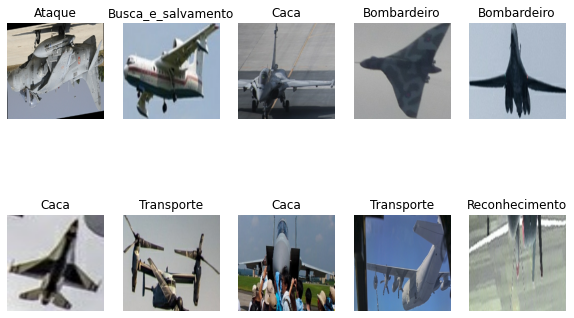

In [22]:
# mostrar algumas imagens de exemplo
plt.figure(1, figsize=(10, 10))
for x_batch, y_batch in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(x_batch[i].numpy().astype("uint8"))
        plt.title(labels[np.argmax(y_batch[i,:])])
        plt.axis("off")
plt.show()

<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">7. MobileNet: Trainning</h1>
</div>

In [8]:
train_ds = train_ds.cache()
val_ds = val_ds.cache()
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
mobileNetModel_tl = MobileNet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
mobileNetModel_tl.summary()
mobileNetModel_tl.trainable = False

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [15]:
model4 = tf.keras.models.Sequential([
    layers.Rescaling(2./255, offset=-1, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    mobileNetModel_tl,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

In [16]:
model4.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [18]:
Modle_Checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'models/MobileNet.h5',
    monitor='val_accuracy',
    save_best_only='True',
    verbose=1)

In [19]:
Early_Stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
    restore_best_weights='True',
    min_delta=0.01)

In [20]:
epochs = 100
modelMobileNet_tl = model4.fit(train_ds, 
                    validation_data = val_ds,
                    callbacks=[Early_Stopping, Modle_Checkpoint],
                    epochs=epochs)

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 2.8210 - accuracy: 0.3543
Epoch 1: val_accuracy improved from -inf to 0.49667, saving model to models\MobileNet.h5
132/132 [==============================] - 437s 3s/step - loss: 2.8210 - accuracy: 0.3543 - val_loss: 1.3220 - val_accuracy: 0.4967
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 1.2462 - accuracy: 0.4887
Epoch 2: val_accuracy improved from 0.49667 to 0.62619, saving model to models\MobileNet.h5
132/132 [==============================] - 406s 3s/step - loss: 1.2462 - accuracy: 0.4887 - val_loss: 0.9352 - val_accuracy: 0.6262
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 1.0780 - accuracy: 0.5633
Epoch 3: val_accuracy improved from 0.62619 to 0.67405, saving model to models\MobileNet.h5
132/132 [==============================] - 394s 3s/step - loss: 1.0780 - accuracy: 0.5633 - val_loss: 0.8750 - val_accuracy: 0.6740
Epoch 4/100
132/132 [===================

Epoch 24/100
132/132 [==============================] - ETA: 0s - loss: 0.4900 - accuracy: 0.8205
Epoch 24: val_accuracy improved from 0.81048 to 0.81929, saving model to models\MobileNet.h5
132/132 [==============================] - 306s 2s/step - loss: 0.4900 - accuracy: 0.8205 - val_loss: 0.5535 - val_accuracy: 0.8193
Epoch 25/100
132/132 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.8208
Epoch 25: val_accuracy did not improve from 0.81929
132/132 [==============================] - 298s 2s/step - loss: 0.4901 - accuracy: 0.8208 - val_loss: 0.6594 - val_accuracy: 0.7979
Epoch 26/100
132/132 [==============================] - ETA: 0s - loss: 0.4852 - accuracy: 0.8226
Epoch 26: val_accuracy did not improve from 0.81929
132/132 [==============================] - 298s 2s/step - loss: 0.4852 - accuracy: 0.8226 - val_loss: 0.6807 - val_accuracy: 0.7914
Epoch 27/100
132/132 [==============================] - ETA: 0s - loss: 0.4772 - accuracy: 0.8270
Epoch 27: val_a

<div style="background-image: url('images/chain.jpg'); background-size: cover; border-radius: 20px; width: 100%;">
    <h1 style="color: white; padding: 20px;">8. MobileNet: Evaluation </h1>
</div>

In [22]:
y_pred = model4.predict(val_ds)
y_pred = tf.argmax(y_pred, axis=1)

33/33 [==============================] - 62s 2s/step


In [23]:
y_true = tf.concat([y for x, y in val_ds], axis=0)
y_true = tf.argmax(y_true, axis=1)

In [24]:
# gerar  graficos e matriz de confusao
cm4 = confusion_matrix(y_true, y_pred)

In [ ]:
acc = modelMobileNet_tl.history['accuracy']
val_acc = modelMobileNet_tl.history['val_accuracy']
loss = modelMobileNet_tl.history['loss']
val_loss = modelMobileNet_tl.history['val_loss']

In [26]:
epochs_range = modelMobileNet_tl.epoch
range(0, max(epochs_range))

range(0, 48)

Text(0.5, 1.0, 'Training and Validation Loss')

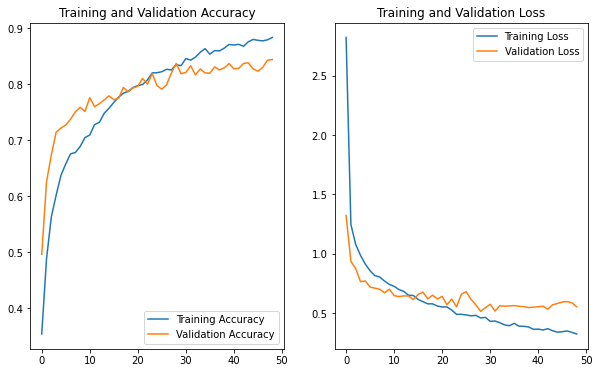

In [27]:
plt.figure(2, figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(0, max(epochs_range) + 1), acc, label='Training Accuracy')
plt.plot(range(0, max(epochs_range) + 1), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(0, max(epochs_range) + 1), loss, label='Training Loss')
plt.plot(range(0, max(epochs_range) + 1), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

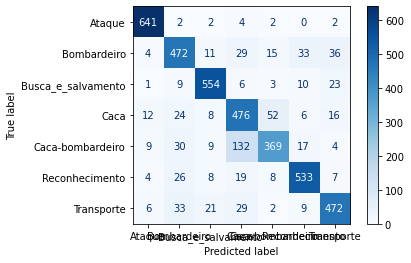

In [40]:
# matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [41]:
accuracy = accuracy_score(y_true, y_pred)
print("Accurary =", accuracy)

Accurary = 0.8373809523809523
